## Building load forecasting: Hospital in SF

We can train a forecaster on another commom energy problem. In this, case we are training a 1-step ahead forecaster to predict the electricity consumption of a building.

The dataset contains one year of hourly observations.
The training will occur on 11 months of the data, reserving the last month for evaluation.

In [1]:
if 'google.colab' in str(get_ipython()):
    !pip install git+https://github.com/ourownstory/neural_prophet.git # may take a while
    #!pip install neuralprophet # much faster, but may not have the latest upgrades/bugfixes
    
import pandas as pd
from neuralprophet import NeuralProphet, set_log_level
# set_log_level("ERROR")

In [2]:
# data_location = "https://raw.githubusercontent.com/ourownstory/neuralprophet-data/main/datasets/"
data_location = '../../../neuralprophet-data/datasets/'

sf_load_df = pd.read_csv(data_location +  'energy/SF_hospital_load.csv')

In [3]:
sf_load_df.head(3)

,ds,y
0,2015-01-01 01:00:00,778.007969
1,2015-01-01 02:00:00,776.241750
2,2015-01-01 03:00:00,779.357338


### Generic forecast: Time-based features only
In this first section, we will train a model with time-features only like we would do with Facebook Prophet.

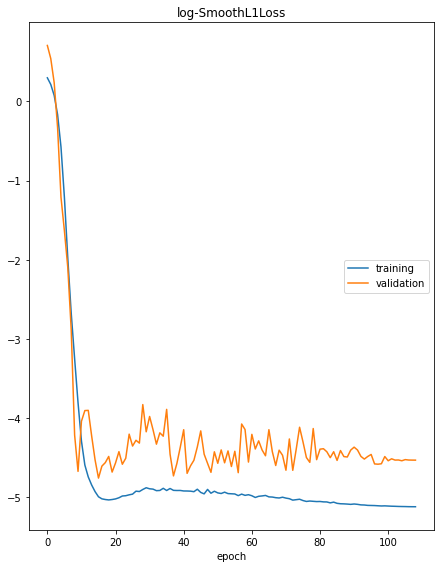

log-SmoothL1Loss
	training         	 (min:   -5.121, max:    0.299, cur:   -5.121)
	validation       	 (min:   -4.759, max:    0.708, cur:   -4.533)


In [4]:
m = NeuralProphet(
    weekly_seasonality=6,
    daily_seasonality=10,
    trend_reg=1,
    learning_rate=0.01,
)
df_train, df_test = m.split_df(sf_load_df, freq='H', valid_p = 1.0/12)

metrics = m.fit(df_train, freq='H', validation_df=df_test, progress='plot')

In [5]:
metrics.tail(1)

,SmoothL1Loss,MAE,RMSE,RegLoss,SmoothL1Loss_val,MAE_val,RMSE_val
108,0.005967,45.749192,63.348728,0.002313,0.010752,61.224743,87.686302


INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.988% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.988% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H


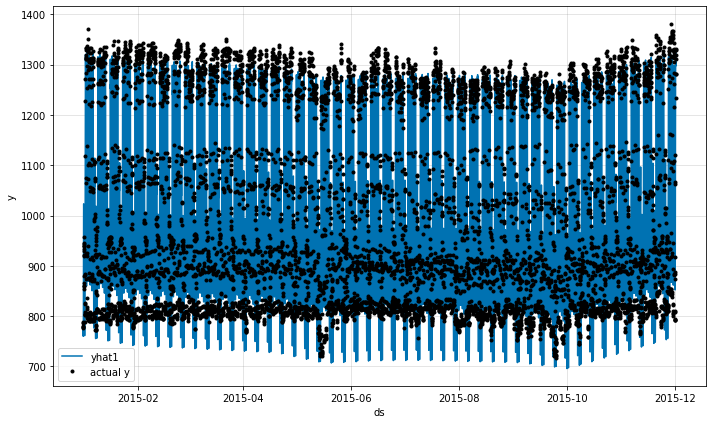

In [6]:
forecast = m.predict(df_train)
fig = m.plot(forecast)

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.863% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.863% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H


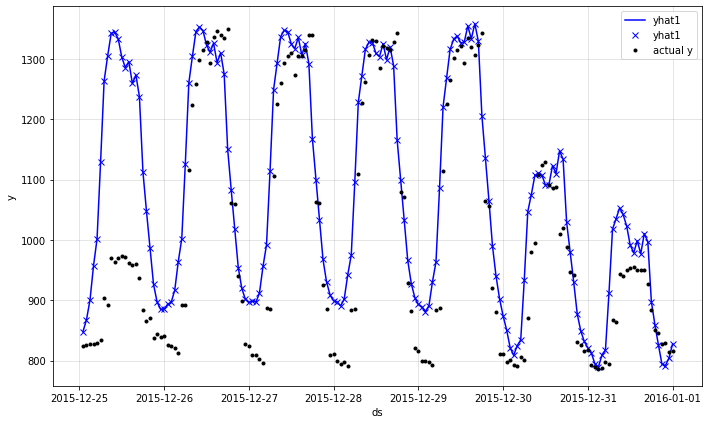

In [7]:
forecast = m.predict(df_test)
m = m.highlight_nth_step_ahead_of_each_forecast(1)
fig = m.plot(forecast[-7*24:])

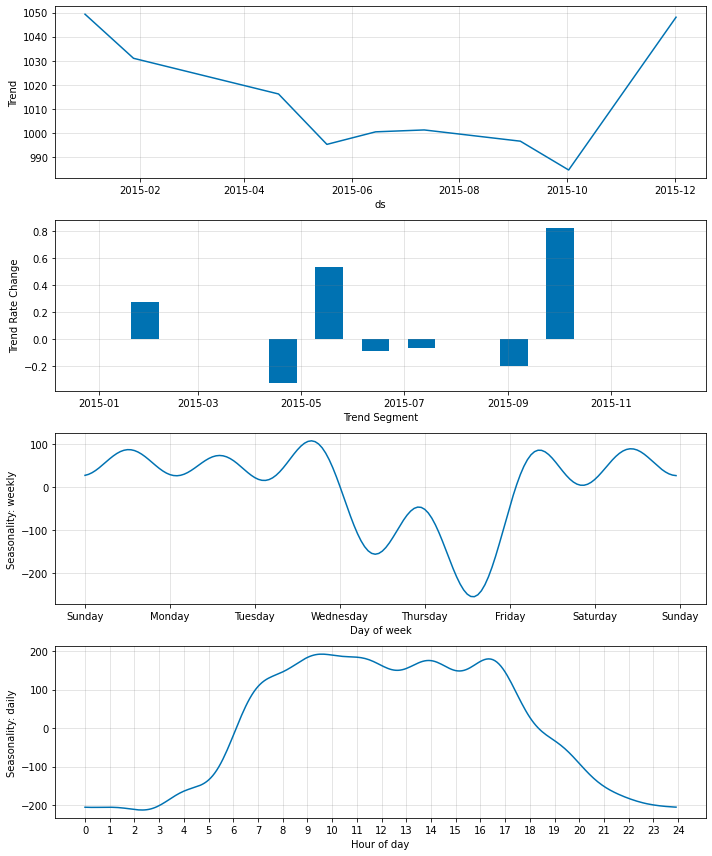

In [8]:
fig_param = m.plot_parameters()

## 1-step ahead forecast with Auto-Regression

In [9]:
m = NeuralProphet(
    growth='off',
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=False,
    n_lags=3*24,
    ar_reg=1,
    learning_rate = 0.01,
)
df_train, df_test = m.split_df(sf_load_df, freq='H', valid_p = 1.0/12)

metrics = m.fit(df_train, freq='H', validation_df=df_test, progress='plot')

TypeError: __init__() got an unexpected keyword argument 'ar_reg'

In [ ]:
metrics.tail(1)

In [ ]:
forecast = m.predict(df_train)
fig = m.plot(forecast)

In [ ]:
forecast = m.predict(df_test)
m = m.highlight_nth_step_ahead_of_each_forecast(1)
fig = m.plot(forecast[-7*24:])

In [ ]:
fig_param = m.plot_parameters()

## 1 step ahead forecast with AR-Net: Using a Neural Network
Here, we will use the power of a neural Network to fit non-linear patterns.

In [ ]:
m = NeuralProphet(
    growth='off',
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=False,
    n_lags=3*24,
    num_hidden_layers=4,
    d_hidden=32,
    learning_rate=0.003,
)
df_train, df_test = m.split_df(sf_load_df, freq='H', valid_p = 1.0/12)

metrics = m.fit(df_train, freq='H', validation_df=df_test, progress='plot')

In [ ]:
metrics.tail(1)

In [ ]:
forecast = m.predict(df_train)
fig = m.plot(forecast)

In [ ]:
forecast = m.predict(df_test)
m = m.highlight_nth_step_ahead_of_each_forecast(1)
fig = m.plot(forecast[-7*24:])

In [ ]:
fig_comp = m.plot_components(forecast[-7*24:])